In [1]:
import pandas as pd
import glob
import nibabel as nib
from scipy.stats import norm
from nilearn.glm.second_level import SecondLevelModel
import matplotlib.pyplot as plt
from nilearn import plotting

In [2]:
data = glob.glob('/Volumes/QCI/ZY/zy_seedFC_all_data135/*.nii.gz')
second_level_input = data
design_matrix = pd.DataFrame(
    [1] * len(second_level_input),
    columns=["intercept"],
)

In [3]:
second_level_model = SecondLevelModel(smoothing_fwhm=8.0, n_jobs=2)
second_level_model = second_level_model.fit(
    second_level_input,
    design_matrix=design_matrix,
)

In [27]:
z_map = second_level_model.compute_contrast(
    second_level_contrast="intercept",
    output_type="z_score",
)

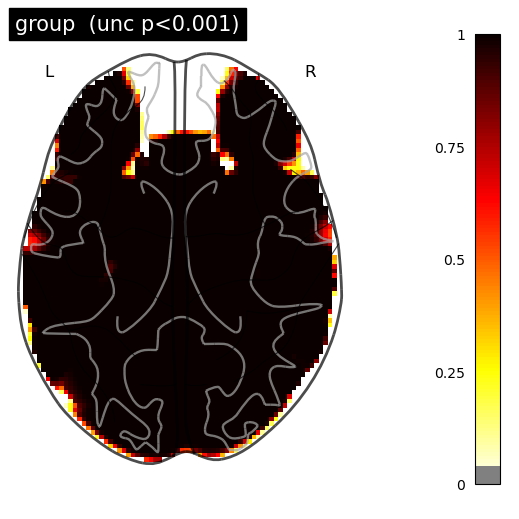

In [30]:
p_val = 0.001
p001_unc = norm.isf(p_val)   # p001_unc = 3.090232306167813
display = plotting.plot_glass_brain(
    z_map,
    threshold=p001_unc,
    colorbar=True,
    display_mode="z",
    plot_abs=False,
    title="group  (unc p<0.001)",
    figure=plt.figure(figsize=(5, 5)),
)
plotting.show()

In [7]:
import numpy as np

from nilearn.image import get_data, math_img

p_val = second_level_model.compute_contrast(output_type="p_value")
n_voxels = np.sum(get_data(second_level_model.masker_.mask_img_))
# Correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img(
    f"-np.log10(np.minimum(1, img * {n_voxels!s}))",
    img=p_val,
)


<string>:1: RuntimeWarning: divide by zero encountered in log10


In [8]:
from nilearn.glm.second_level import non_parametric_inference

out_dict = non_parametric_inference(
    second_level_input,
    design_matrix=design_matrix,
    model_intercept=True,
    n_perm=500,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=False,
    smoothing_fwhm=8.0,
    n_jobs=2,
    threshold=0.001,
)

/Users/qingchen/anaconda3/lib/python3.10/site-packages/nilearn/mass_univariate/permuted_least_squares.py:993: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/qingchen/anaconda3/lib/python3.10/site-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


/Users/qingchen/anaconda3/lib/python3.10/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


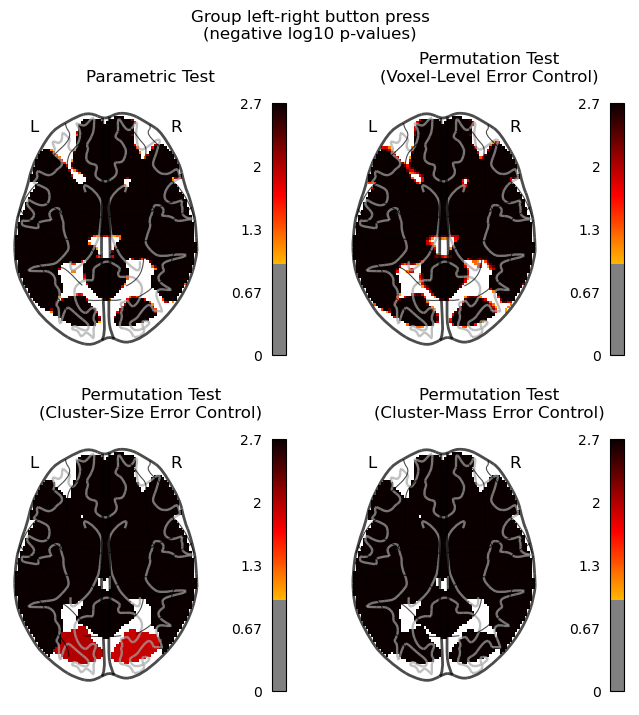

In [9]:
import itertools

threshold = 1  # p < 0.1
vmax = 2.69  # ~= -np.log10(1 / 500)

cut_coords = [0]

IMAGES = [
    neg_log_pval,
    out_dict["logp_max_t"],
    out_dict["logp_max_size"],
    out_dict["logp_max_mass"],
]
TITLES = [
    "Parametric Test",
    "Permutation Test\n(Voxel-Level Error Control)",
    "Permutation Test\n(Cluster-Size Error Control)",
    "Permutation Test\n(Cluster-Mass Error Control)",
]

fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)
for img_counter, (i_row, j_col) in enumerate(
    itertools.product(range(2), range(2))
):
    ax = axes[i_row, j_col]
    plotting.plot_glass_brain(
        IMAGES[img_counter],
        colorbar=True,
        vmax=vmax,
        display_mode="z",
        plot_abs=False,
        cut_coords=cut_coords,
        threshold=threshold,
        figure=fig,
        axes=ax,
    )
    ax.set_title(TITLES[img_counter])
fig.suptitle("Group left-right button press\n(negative log10 p-values)")
plt.show()